In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D ,SeparableConv2D, MaxPooling2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from numpy import loadtxt
from sklearn.metrics import f1_score, recall_score, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
debug = True

combined_dataset = pd.read_csv("/kaggle/input/amazon-kaggle-smote/Amazon_Kaggle_SMOTE.csv", delimiter=',')
print(combined_dataset)
all_scores = {}
batch_size = 16
epochs = 30

2024-10-23 02:33:20.680276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 02:33:20.680423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 02:33:20.815097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


          0     1       2       3       4       5       6       7       8  \
0      7780  1616    6831  117961  117969    6725  125687  202487    6725   
1      8208  3725   20412  117890  117891  117878  117879  117879   19721   
2      1062  6982   51172  117961  118225  120551  120690  120691  290919   
3      3288  7102   46788  117929  117940  117920  118568  163031   19721   
4      8278  5785   19881  118006  118007  117941  118568  292195   19721   
...     ...   ...     ...     ...     ...     ...     ...     ...     ...   
61739  7661  6768  114380  118017  118194  118361  118362  127893   19758   
61740  3059  2406   62258  119073  119158  125282  118955  130322  118950   
61741  6428  4147    5312  117958  117959  117920  118568  122780   19721   
61742  1454  5151    4670  117945  118234  119223  118430  130266  118194   
61743  5520  1703    5252  117961  118187  120142  118556  117906  290919   

            9     10  11  
0      125689  20895   1  
1      117880  31441 

In [2]:
x_ = combined_dataset.drop(columns=['11'])
y_ = combined_dataset.filter(['11'])
x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.2, random_state=42)

# Reshape input data
x_train = x_train.values.reshape(-1, x_train.shape[1], 1, 1)
x_test = x_test.values.reshape(-1, x_test.shape[1], 1, 1)

if debug:
    print('shape of x_train after reshaping', x_train.shape)
    print('shape of x_test after reshaping', x_test.shape)

#determine batch size
batch_size = min(x_train.shape[0] / 10, batch_size)
if debug:
    print('batch size: ' + str(batch_size))

# Modify input shape accordingly
input_shape = (x_train.shape[1], 1, 1)
# Create the input layer
inputs = Input(shape=input_shape)

# Entry Flow
x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

previous_block_activation = x
for size in [128, 256, 728]:
    x = Activation('relu')(x)
    x = Conv2D(size, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = Conv2D(size, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    residual = Conv2D(size, (1, 1), strides=(2, 2), padding='same')(previous_block_activation)
    x = add([x, residual])
    previous_block_activation = x

def middle_flow(x, num_blocks=8):
    previous_block_activation = x

    for _ in range(num_blocks):
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = add([x, previous_block_activation])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x

def exit_flow(x, num_classes):
    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(  # Project residual
        1024, 1, strides=2, padding='same')(previous_block_activation)
    x = add([x, residual])  # Add back residual

    x = SeparableConv2D(1536, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(2048, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)

    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    return Dense(num_classes, activation=activation)(x)



# Define the number of classes based on your task
num_classes = 1  # Adjust this according to your task

# Final Dense Layer
x = GlobalAveragePooling2D()(x)
if num_classes == 1:
    activation = 'sigmoid'
else:
    activation = 'softmax'
outputs = Dense(num_classes, activation=activation)(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

shape of x_train after reshaping (49395, 11, 1, 1)
shape of x_test after reshaping (12349, 11, 1, 1)
batch size: 16
Train on 49395 samples
Epoch 1/30
49395/49395 [==============================] - 41s 837us/sample - loss: 0.7139 - acc: 0.5460
Epoch 2/30
49395/49395 [==============================] - 37s 745us/sample - loss: 0.6761 - acc: 0.5733
Epoch 3/30
49395/49395 [==============================] - 37s 756us/sample - loss: 0.6615 - acc: 0.5942
Epoch 4/30
49395/49395 [==============================] - 37s 756us/sample - loss: 0.6518 - acc: 0.6074
Epoch 5/30
49395/49395 [==============================] - 37s 752us/sample - loss: 0.6400 - acc: 0.6231
Epoch 6/30
49395/49395 [==============================] - 37s 753us/sample - loss: 0.6290 - acc: 0.6368
Epoch 7/30
49395/49395 [==============================] - 37s 755us/sample - loss: 0.6179 - acc: 0.6479
Epoch 8/30
49395/49395 [==============================] - 37s 756us/sample - loss: 0.6058 - acc: 0.6604
Epoch 9/30
49395/49395 [=====

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [3]:
y_test = np.array(y_test)
y_test = y_test.flatten()
y_pred = y_pred.flatten()

Confusion Matrix: [[4728 1497]
 [1133 4991]]


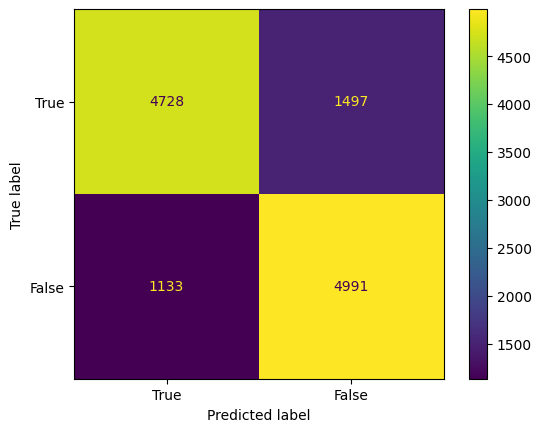

FPR: 0.24048192771084337 TPR: 0.8149902024820379


In [4]:
from sklearn import metrics
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:",cm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [True, False])
cm_display.plot()
plt.savefig('/kaggle/working/xception_cm.png')
plt.show()

fpr_cm = cm[0, 1] / (cm[0, 1] + cm[0, 0])
tpr_cm = cm[1, 1] / (cm[1, 1] + cm[1, 0])

print("FPR:", fpr_cm, "TPR:", tpr_cm)

ROC: 0.7872541373855972


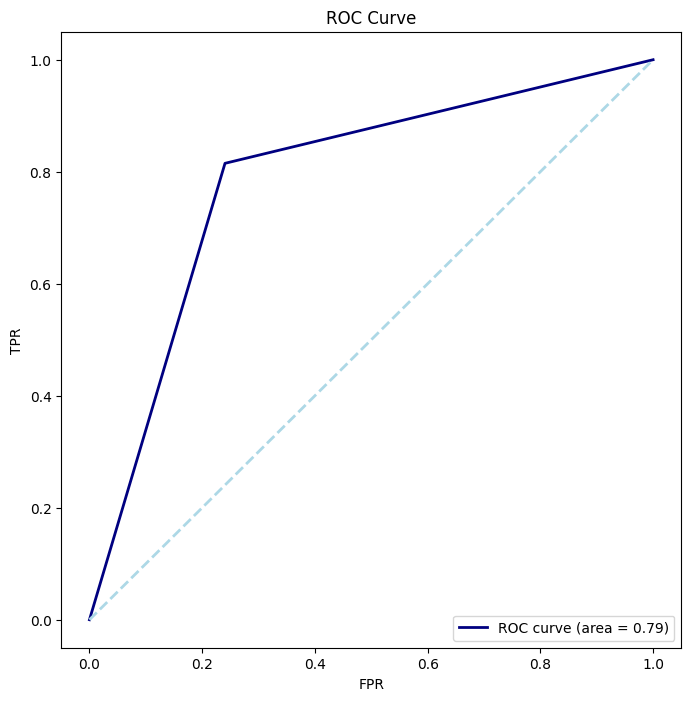

In [5]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("ROC:",roc_auc)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='navy', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('/kaggle/working/xception_roc.png')
plt.show()

PRC: 0.8380024300192693


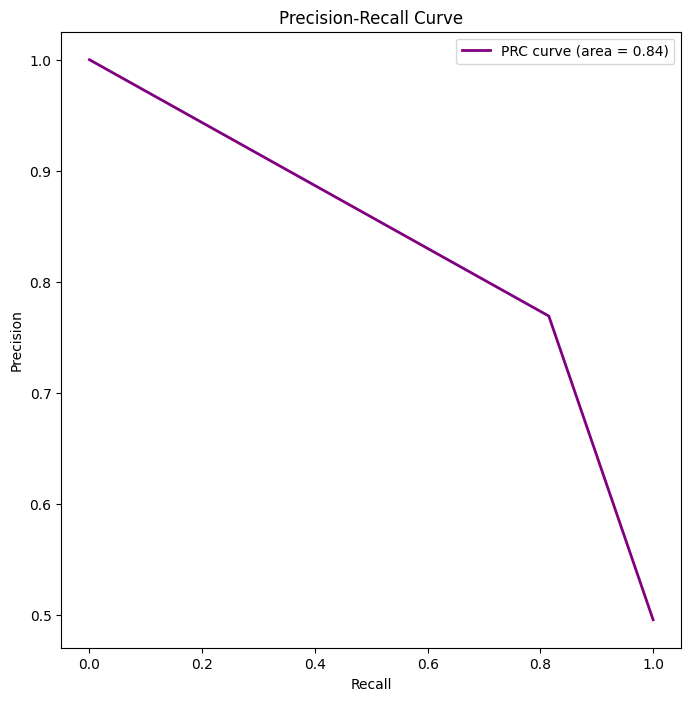

In [6]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
prc_auc = auc(recall, precision)
print("PRC:",prc_auc)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='purple', lw=2, label='PRC curve (area = {:.2f})'.format(prc_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.savefig('/kaggle/working/xception_prc.png')
plt.show()

In [7]:
f1_score_value = f1_score(y_test, y_pred, average='macro')
recall_score_value = recall_score(y_test, y_pred, average='macro')
precision_score_value = average_precision_score(y_test, y_pred, average = 'macro')

print("F1 score:",f1_score_value,"recall score:", recall_score_value, "precision score:", precision_score_value)

F1 score: 0.7869306469928825 recall score: 0.7872541373855972 precision score: 0.7186928481526553


In [8]:
print(fpr)
print(tpr)
print(precision)
print(recall)

[0.         0.24048193 1.        ]
[0.        0.8149902 1.       ]
[0.4959106  0.76926634 1.        ]
[1.        0.8149902 0.       ]


In [9]:
print(fpr_cm)
print(tpr_cm)
print(precision_score_value)
print(recall_score_value)

0.24048192771084337
0.8149902024820379
0.7186928481526553
0.7872541373855972


In [10]:
all_scores= {
    'F1 Score': f1_score_value,
    'Recall value': recall_score_value,
    'Precision value': precision_score_value,
    'FPR value': fpr_cm,
    'TPR value': tpr_cm,
    'FPR list' : fpr,
    'TPR list': tpr,
    'Recall list':recall,
    'Precision list':precision,
    'ROC AUC': roc_auc,
    'PRC AUC': prc_auc
    }
print('F1 Score:', f1_score_value)
print('Recall value:', recall_score_value)
print('FPR value:', fpr_cm)
print('TPR value:', tpr_cm)
print('ROC AUC:', roc_auc)
print('PRC AUC:', prc_auc)
print('All Scores:', all_scores)

F1 Score: 0.7869306469928825
Recall value: 0.7872541373855972
FPR value: 0.24048192771084337
TPR value: 0.8149902024820379
ROC AUC: 0.7872541373855972
PRC AUC: 0.8380024300192693
All Scores: {'F1 Score': 0.7869306469928825, 'Recall value': 0.7872541373855972, 'Precision value': 0.7186928481526553, 'FPR value': 0.24048192771084337, 'TPR value': 0.8149902024820379, 'FPR list': array([0.        , 0.24048193, 1.        ]), 'TPR list': array([0.       , 0.8149902, 1.       ]), 'Recall list': array([1.       , 0.8149902, 0.       ]), 'Precision list': array([0.4959106 , 0.76926634, 1.        ]), 'ROC AUC': 0.7872541373855972, 'PRC AUC': 0.8380024300192693}


In [11]:
output_file_path = '/kaggle/working/xception_amazon_smote.txt'
with open(output_file_path, 'w') as f: 
    f.write(": {}\n".format(all_scores))

In [12]:
import json
dict_string = json.dumps(all_scores)
file_path = '/kaggle/working/output.txt'

with open(file_path, 'w') as file:
    file.write(dict_string)

scores_table = pd.DataFrame({
    'Metric': ['F1 Score', 'True Positive Rate', 'False Positive Rate'],
    'Score': [f1_score_value, tpr_cm, fpr_cm]
})
scores_table.to_csv('/kaggle/working/scores_table.csv', index=False)
print(scores_table)

TypeError: Object of type ndarray is not JSON serializable

In [13]:
arrays_ = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
arrays_.to_csv('/kaggle/working/pred_array_output_file.csv', index=False)

In [14]:
from tensorflow.keras.models import save_model
model.save('/kaggle/working/xception_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
pr_arrays = pd.DataFrame({'tpr':tpr,'fpr':fpr})
pr_arrays.to_csv('/kaggle/working/pr_array_output.csv',index= False)

In [16]:


import json

# Assuming tpr and fpr are NumPy arrays
print("Type of f1:", type(f1_score_value))
print("Type of precision:", type(precision))
print("Type of recall:", type(recall))
print("Type of tpr_value:", type(tpr_cm))
print("Type of fpr_value:", type(fpr_cm))
print("Type of roc_auc:", type(roc_auc))
print("Type of prc_auc:", type(prc_auc))
print("Type of tpr:", type(tpr))
print("Type of fpr:", type(fpr))

precision_list = precision.tolist()
recall_list = recall.tolist()
tpr_list = tpr.tolist()
fpr_list = fpr.tolist()

#print(f1.type())

data = {
    "Average F1 Score": float(f1_score_value), 
    "Average Precision": float(precision_score_value), 
    "Average Recall": float(recall_score_value), 
    "Average True Positive Rate": float(tpr_cm), 
    "Average False Positive Rate": float(fpr_cm), 
    "Average ROC AUC": roc_auc, 
    "Average PRC AUC": prc_auc,
    "TPR Array" : tpr_list,
    "FPR Array" : fpr_list,
    "Precision Array": precision_list, 
    "Recall Array": recall_list
}

# Specify the file path
file_path = "/kaggle/working/Xception - Real SMOTE - Lenny.json"

# Write the data to a JSON file
with open(file_path, "w") as json_file:
    json.dump(data, json_file)

Type of f1: <class 'numpy.float64'>
Type of precision: <class 'numpy.ndarray'>
Type of recall: <class 'numpy.ndarray'>
Type of tpr_value: <class 'numpy.float64'>
Type of fpr_value: <class 'numpy.float64'>
Type of roc_auc: <class 'numpy.float64'>
Type of prc_auc: <class 'numpy.float64'>
Type of tpr: <class 'numpy.ndarray'>
Type of fpr: <class 'numpy.ndarray'>
